In [23]:
import numpy as np
import util
import matplotlib.pyplot as plt
from linear_model import LinearModel


In [24]:
ds3_test_path = '/home/kev/Documents/cs229/cs229-2018-autumn/problem-sets/PS1/data/ds3_test.csv'
ds3_valid_path = '/home/kev/Documents/cs229/cs229-2018-autumn/problem-sets/PS1/data/ds3_valid.csv'
ds3_train_path = '/home/kev/Documents/cs229/cs229-2018-autumn/problem-sets/PS1/data/ds3_train.csv'

In [97]:
x_train, y_train = util.load_dataset(ds3_train_path, add_intercept=True)
_, t_train = util.load_dataset(ds3_train_path, label_col='t', add_intercept=True)
x_test, y_test = util.load_dataset(ds3_test_path, add_intercept=True)
_, t_test = util.load_dataset(ds3_test_path, label_col='t', add_intercept=True)
x_valid, y_valid = util.load_dataset(ds3_valid_path, add_intercept=True)
_, t_valid = util.load_dataset(ds3_valid_path, label_col='t', add_intercept=True)

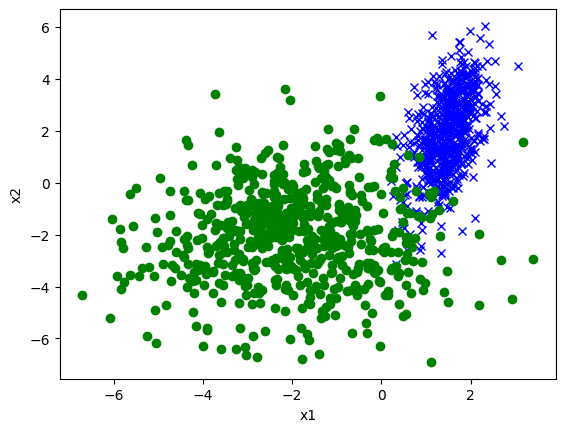

In [26]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x_train[t_train==1, -2], x_train[t_train==1, -1], "bx", linewidth=2)
plt.plot(x_train[t_train==0, -2], x_train[t_train==0, -1], "go", linewidth=2)


In [81]:
class LogisticRegression1(LinearModel):
    def fit(self, x, y):
        m,n = x.shape 
        self.theta = np.zeros((n,1))

        def sigmoid(theta, x):
            z = x @ theta
            positive_mask = z >= 0
            negative_mask = ~positive_mask
            result = np.zeros_like(z)

            # For positive z, use the standard sigmoid computation
            result[positive_mask] = 1 / (1 + np.exp(-z[positive_mask]))

            # For negative z, compute sigmoid in a way that avoids overflow
            exp_z = np.exp(z[negative_mask])
            result[negative_mask] = exp_z / (1 + exp_z)

            return result

        def gradient(x, y, theta):
            hyp = sigmoid(theta, x)
            y_reshaped = y.reshape(-1,1)
            return 1/m * x.T @ (hyp - y_reshaped)
            
        old_theta = self.theta
        new_theta = old_theta + self.step_size * gradient(x, y, old_theta)
        while(np.linalg.norm((new_theta - old_theta),1) >= self.eps):
            old_theta = new_theta
            new_theta = old_theta + self.step_size * gradient(x, y, old_theta)

        self.theta = new_theta

    def predict(self, x):
        probabilities = 1 / (1 + np.exp(-np.dot(x, self.theta)))
        return probabilities >= 0.5  # Applying threshold to convert probabilities to binary labels

    

In [113]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """
        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return -1 / m * np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros(n)

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)

        self.theta = new_theta

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """
        probabilities = 1 / (1 + np.exp(-np.dot(x, self.theta)))
        return probabilities >= 0.5

In [111]:
log_reg = LogisticRegression(eps =1e-5)
log_reg.fit(x_train, y_train)
print("The accuracy on training set is: ", np.mean(log_reg.predict(x_train) == y_train))

The accuracy on training set is:  0.9


In [114]:
def h(theta, x):
    """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

    :param theta: Shape (n,).
    :param x:     All training examples of shape (m, n).
    :return:      The hypothesis for all training examples. Shape (m,).
    """
    return 1 / (1 + np.exp(-np.dot(x, theta)))

v_plus= x_valid[y_valid == 1]
alpha = h(log_reg.theta, v_plus).mean()

def predict(x):
    probabilities = 1 / (1 + np.exp(-np.dot(x, log_reg.theta)))
    return probabilities/alpha >= 0.5

In [115]:
theta_prime = log_reg.theta + np.log(2 / alpha - 1) * np.array([1, 0, 0])

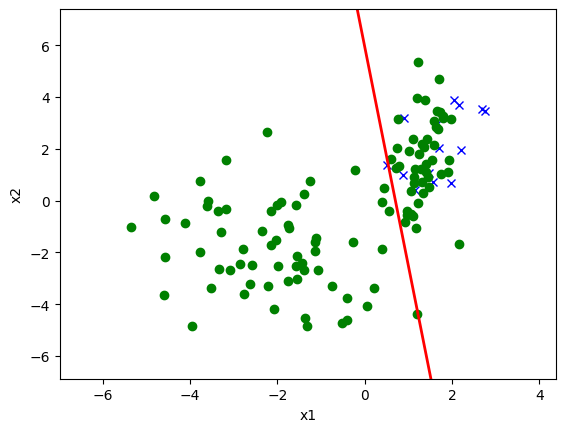

In [116]:
util.plot(x_test, y_test, theta_prime)